<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/1.%D0%93%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Написать Генетический алгоритм для обучения нейронных сетей, в котором:.

- Сделайте возможность бота создать любую последовательность слоев. Количество слоев должно задаваться ботом.
- Добавьте возможность управлять появлением Dropout слоев.
- Можно жёстко настроить появление Flatten и полносвязные слои только в конце.
- Полносвязные слои ГА также может генерить в произвольном количестве (количество слоев содержиться в боте).


In [3]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)

Gen RAM Free: 12.6 GB  | Proc size: 376.8 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB
GPU Model:  Tesla T4


###Загрузки:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils                                              # Для to_categorical
import numpy as np 
from keras.optimizers import Adam 
from keras.models import Sequential, Model                                      # Два варианты моделей
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D#Стандартные слои
from keras.losses import MAE
from google.colab import files                                                  # Загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler                  # Нормировщики
from keras.preprocessing.sequence import TimeseriesGenerator                    # Для генерации выборки временных рядов
import keras.backend as K
import random as random
from PIL import Image                                                           # Импортируем одель Image для обработки изображений
import time
from tensorflow.keras.utils import plot_model
from IPython.display import clear_output, Image
Image("/content/drive/MyDrive/Logo/logo9.png", width=200, height=90)
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Подбор архитектуры свёрточной сети

###Загрузка базы:

In [3]:
base_data = pd.read_csv('/content/drive/My Drive/traff.csv',header=None)

In [4]:
base_data

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
...,...,...
1090,12/27/2019,"29,801.00"
1091,12/28/2019,"34,913.00"
1092,12/29/2019,"37,665.00"
1093,12/30/2019,"32,643.00"


In [5]:
data = base_data.iloc[:,1]

In [6]:
d = data
print("Сколько есть записей:", len(d))              
print("Длинна одной строки данных:", len(d.iloc[0]))      
print("Пример первой строки данных:", d.iloc[0]) 

Сколько есть записей: 1095
Длинна одной строки данных: 9
Пример первой строки данных: 22,226.00


In [7]:
data = np.array(data) # data в нампай-массив
for i in range(len(data)):
    data[i] = float(data[i].replace(',',''))

###Функция загрузки данных:

In [8]:
xLen = 60                                                   # Анализируем по 300 прошедшим точкам 
valLen = 300                                                # Используем 300 записей для проверки
trainLen = data.shape[0]-valLen                             # Размер тренировочной выборки

# Делим данные на тренировочную и тестовую выборки:

Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке:

Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)

trainDataGen = TimeseriesGenerator(Train, Train,length=xLen, sampling_rate=1, batch_size=20)   # Создаю генератор Train:             
testDataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=20)     # Создаю генератор Test"

###Функции для отображения результатов getPred:
- Функция рассчитывает результаты прогнозирования сети
- В аргументы принимает сеть (currModel) и проверочную выборку
- Выдаёт результаты предсказания predVal
-И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)

In [9]:
def getPred(currModel, xVal, yVal, yScaler):

    predVal = yScaler.inverse_transform(currModel.predict(xVal))      # Предсказываем ответ сети по проверочной выборке
    yValUnscaled = yScaler.inverse_transform(yVal)                    # И возвращаем исходны масштаб данных, до нормализации
    
    return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):         # Функция визуализирует графики, что предсказала сеть и какие были правильные ответы

#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем

    plt.plot(predVal[start:start+step, channel], label='Прогноз')
    plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение Close')
    plt.legend()
    plt.show()
  

def correlate(a, b):                                                  # Функция рассчёта корреляции дух одномерных векторов

    ma = a.mean()                                                     # Среднее значение первого вектора
    mb = b.mean()                                                     # Среднее значение второго вектора
    mab = (a*b).mean()                                                # Среднее значение произведения векторов
    sa = a.std()                                                      # Среднеквадратичное отклонение первого вектора
    sb = b.std()                                                      # Среднеквадратичное отклонение второго вектора
    
    #Рассчитываем корреляцию
    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val


def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):  # Функция рисует корреляцию прогнозированного сигнала с правильным

#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
#showGraf - показываем график или нет
#returnData - возвращаем массивы автокорреляции или нет


    for ch in channels:                                   # Проходим по всем каналам
      corr = []                                           # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
      yLen = yValUnscaled.shape[0]                        # Запоминаем размер проверочной выборки

      for i in range(corrSteps):                          # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
          # Получаем сигнал, смещённый на i шагов назад
          # predVal[i:, ch]
          # Сравниваем его с верными ответами, без смещения назад
          # yValUnscaled[:yLen-i,ch]
          # Рассчитываем их корреляцию и добавляем в лист
          corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

      own_corr = []                                       # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      for i in range(corrSteps):                          # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
          # Получаем сигнал, смещённый на i шагов назад
          # predVal[i:, ch]
          # Сравниваем его с верными ответами, без смещения назад
          # yValUnscaled[:yLen-i,ch]
          # Рассчитываем их корреляцию и добавляем в лист
          own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

      if showGraf:                                        # Отображаем график коррелций для данного шага,eсли нужно показать график
        plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
        plt.plot(own_corr, label='Эталон')

    if showGraf:                                          #Если нужно показать график
      plt.xlabel('Время')
      plt.ylabel('Значение')
      plt.legend()
      plt.show()

    if returnData:                                        #Если нужно вернуть массивы автокорреляции
      return corr, own_corr

###Генерируем проверочную выборку:
- Создаю генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки

In [10]:
DataGen = TimeseriesGenerator(Test, Test,length=xLen, sampling_rate=1,
                               batch_size=len(Test)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
    xVal.append(i[0])
    yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

# Подбор линейной архитектуры



**Входной слой**

*   0 - делаем ли нормализацию
*   1 - размер первого свёрточного слоя
*   2 - ядро первого свёрточного слоя 
*   3 - функция активации первого слоя
*   4 - делаем ли MaxPooling0
*   5 - размер MaxPooling0

**Определяем кол-во сверточных слоев**

*   6 - Делаем ли сверточные слои
*   7 - размер сверточного слоя
*   8 - ядро сверточного слоя
*   9 - делаем ли MaxPooling
*   10 - размер MaxPooling
*   11- делаем ли Dropout
*   12 - размер Dropout
*   13 - функция активации для сверточных слоев

----
*   14 - функция активации предпоследнего слоя
*   15 - функция активации выходного слоя
----
**Предпоследний скрытый слой**

*   16 - делаем ли финальную нормализацию 
*   17 - размер предпоследнего полносвязного слоя

In [94]:
def createConvNet(net):

    model = Sequential()             # Создаем моель Sequential
    
    makeFirstNormalization = net[0]  # Делаем ли нормализацию в начале
    firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
    firstConvKernel = net[2]         # Ядро первого свёрточного слоя
    activation0 = net[3]             # Функция активации входного слоя
    makeMaxPooling0 = net[4]         # Делаем ли maxpooling для нулевого слоя
    maxPoolingSize0 = net[5]         # Размер MaxPooling

    makeNumberConv = net[6]          # определяем кол-во сверточных слоев
    ConvSize = 2 ** net[7]           # Размер №-го свёрточного слоя
    ConvKernel = net[8]              # Ядро №-го свёрточного слоя
    makeMaxPooling = net[9]          # Делаем ли MaxPooling
    maxPoolingSize = net[10]         # Размер MaxPooling
    makeDropout = net[11]            # Делаем ли Dropout
    makeDropoutSize = net[12]        # Размер Dropout
    activation1 = net[13]            # Функция активации для сверточных слоев

    activation2 = net[14]            # Функция активации для предпоследнего слоя
    activation3 = net[15]            # Функция активации для выходного слоя

    makeSecondNormalization = net[16] # Делаем ли финальную нормализацию
    denseSize = 2 ** net[17]          # Размер полносвязного слоя

    activation_list = ['linear','relu','elu','tanh','softmax','sigmoid','hard_sigmoid'] 
    dropout_list = [0.1, 0.2, 0.3, 0.4]

    if makeFirstNormalization:        # Если делаем нормализацию в начале
      # Добавляем слой BatchNormalization
      model.add(BatchNormalization(input_shape=(xLen, 1))) 
      # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
      model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')) 
    else:
      # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
      model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')) 

    if makeMaxPooling0:                 # Если делаем maxpooling
      model.add(MaxPooling1D(maxPoolingSize0))

    if makeNumberConv:                  # Если делаем еще сверточные слои
        i = 1
        while i <= makeNumberConv:        
            # Добавляем сверточные слои в количестве i
            model.add(Conv1D(ConvSize, ConvKernel, activation=activation_list[activation1], padding='same'))
            #i += 1
            if makeMaxPooling:          # Если делаем MaxPooling
                # Добавляем слой MaxPooling с размером maxPoolingSize
                #model.add(MaxPooling1D(pool_size=maxPoolingSize))
                model.add(MaxPooling1D(pool_size=(2)))
                if makeDropout:         # Если делаем Dropout
                    # Добавляем слой Dropout с размером makeDropoutSize
                    model.add(Dropout(dropout_list[makeDropoutSize]))
            i += 1

    if makeSecondNormalization:     # Если делаем финальную нормализацию
        model.add(BatchNormalization()) # Добавляем слой BatchNormalization
    
    model.add(Flatten())              # Добавляем слой Flatten

    model.add(Dense(denseSize, activation=activation_list[activation2])) # Добавляем слой Dense с denseSize нейронами
    model.add(Dense(1, activation=activation_list[activation3]))         # Добавляем Dense-слой с softmax-активацией и 10 нейронами
    
    return model                     


In [95]:
def evaluateNet(net, ep, verb):               # Функция вычисления результата работы сети
    val = 0
    time.time()
    model = createConvNet(net)                # Создаем модель createConvNet

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-4),loss='mse')

    history = model.fit_generator(trainDataGen, epochs=5, verbose=verb, validation_data=testDataGen)
      
    val = history.history["val_loss"][-1]    # Возвращаем точность на проверочной выборке с последней эпохи
    
    return val, model                        # Возвращаем точность


def createRandomNet():              # Функция создания списка случайных параметров
    net = []
    net.append(random.randint(0,1)) #0.Делаем или нет нормализацию
    net.append(random.randint(3,6)) #1.Первый свёрточный слой от 8 до 64 нейронов
    net.append(random.randint(3,7)) #2.Ядро первого свёрточного слоя от 3 до 7
    net.append(random.randint(0,6)) #3. Функция активации первого слоя
    net.append(random.randint(0,1)) #4.Делаем ли MaxPooling
    net.append(random.randint(2,3)) #5.Размер MaxPooling
    net.append(random.randint(1,4)) #6.определяем кол-во сверточных слоев
    net.append(random.randint(3,10)) #7.Cвёрточный слой от 8 до 1024 нейронов
    net.append(random.randint(3,7)) #8. Ядро второго свёрточного слоя от 3 до 7
    net.append(random.randint(0,1)) #9. Делаем ли MaxPooling
    net.append(random.randint(2,3)) #10.Размер MaxPooling
    net.append(random.randint(0,1)) #11. Делаем ли Dropout
    net.append(random.randint(0,3)) #12.Размер Dropout
    net.append(random.randint(0,6)) #13.Функция активации для сверточных слоев
    net.append(random.randint(0,6)) #14.Функция активации для предпоследнего слоя
    net.append(random.randint(0,6)) #15.Функция активации для выходного слоя
    net.append(random.randint(0,1)) #16.Делаем ли финальную нормализацию
    net.append(random.randint(3,6)) #17. Размер полносвязного слоя

    return net

In [96]:
n = 20              # Общее число ботов
nsurv = 10          # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 18              # Размер бота
epohs = 10          # количество эпох

mut = 0.09          # коэфициент мутаций

popul = []          # Массив популяции
val = []            # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):                 # Пробегаем по всем эпохам
  val = []                              # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):                    # Пробегаем в цикле по всем ботам 
    bot = popul[i]                      # Берем очередного бота
    f, model_sum = evaluateNet(bot, 3, 0) # Вычисляем точность текущего бота
    val.append(f)                       # Добавляем полученное значение в список val
  
  sval = sorted(val, reverse=0)         # Сортируем val
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


0 90.15157556533813   [0.0542861744761467, 0.05506357550621033, 0.06827843934297562, 0.0751519501209259, 0.07858946919441223] [[1, 4, 5, 2, 1, 3, 2, 10, 5, 1, 3, 1, 0, 1, 1, 2, 1, 5], [0, 3, 3, 5, 1, 2, 1, 9, 6, 1, 2, 1, 1, 4, 3, 3, 0, 6], [1, 6, 6, 2, 1, 3, 2, 7, 3, 1, 2, 1, 2, 0, 0, 0, 1, 4], [1, 3, 3, 2, 0, 2, 4, 10, 3, 0, 2, 1, 1, 3, 1, 3, 0, 6], [1, 6, 3, 3, 0, 3, 1, 5, 6, 1, 2, 0, 2, 0, 4, 3, 0, 4]]
1 112.37711143493652   [0.031005676835775375, 0.046139299869537354, 0.05429471656680107, 0.05432155728340149, 0.05650128796696663] [[1, 5, 5, 3, 0, 3, 4, 8, 4, 0, 2, 1, 2, 5, 1, 6, 0, 3], [0, 6, 3, 4, 1, 2, 1, 9, 4, 0, 3, 0, 1, 0, 1, 6, 1, 5], [1, 3, 6, 1, 1, 2, 3, 10, 5, 0, 3, 1, 0, 3, 2, 3, 0, 4], [0, 3, 3, 5, 1, 2, 1, 9, 6, 1, 2, 1, 1, 4, 3, 3, 0, 6], [1, 5, 7, 4, 0, 3, 1, 10, 6, 1, 2, 0, 0, 1, 6, 5, 0, 5]]
2 86.80251359939575   [0.028800128027796745, 0.033969417214393616, 0.050951503217220306, 0.052685800939798355, 0.05575776845216751] [[0, 3, 3, 2, 0, 2, 4, 10, 3, 0, 2, 0, 1, 0, 

In [97]:
print(popul) #Геномы лучших ботов по эпохам

[[0, 3, 3, 2, 0, 3, 1, 10, 4, 1, 3, 0, 1, 0, 3, 3, 0, 6], [0, 3, 3, 2, 0, 3, 4, 10, 4, 1, 3, 0, 1, 0, 1, 6, 0, 6], [0, 3, 3, 4, 0, 3, 3, 10, 3, 1, 3, 0, 1, 2, 0, 6, 0, 6], [0, 3, 3, 2, 0, 3, 4, 10, 7, 0, 2, 1, 2, 2, 5, 6, 0, 5], [0, 3, 3, 4, 0, 3, 4, 10, 3, 1, 3, 0, 1, 0, 0, 6, 0, 6], [0, 3, 3, 4, 0, 3, 3, 10, 5, 0, 3, 0, 1, 0, 1, 6, 0, 6], [0, 3, 3, 4, 0, 3, 4, 10, 3, 1, 3, 0, 1, 0, 0, 6, 0, 6], [0, 3, 3, 2, 0, 3, 4, 10, 4, 1, 3, 0, 3, 0, 1, 6, 0, 6], [0, 3, 5, 4, 0, 3, 2, 10, 3, 1, 3, 0, 1, 3, 5, 6, 0, 6], [1, 3, 3, 4, 0, 3, 3, 10, 5, 0, 3, 1, 1, 2, 0, 1, 0, 6], [0, 3, 5, 4, 0, 3, 2, 4, 3, 1, 3, 0, 1, 3, 5, 6, 0, 6], [0, 3, 3, 1, 0, 3, 4, 10, 3, 0, 3, 1, 2, 0, 5, 6, 0, 5], [1, 5, 3, 4, 0, 3, 4, 10, 3, 1, 3, 0, 1, 2, 1, 6, 0, 6], [0, 3, 3, 2, 0, 3, 1, 10, 4, 1, 2, 1, 2, 0, 5, 6, 0, 6], [0, 3, 3, 4, 0, 3, 3, 10, 4, 0, 3, 1, 1, 2, 5, 6, 0, 6], [0, 3, 3, 2, 0, 3, 4, 10, 7, 1, 2, 0, 2, 0, 5, 6, 0, 6], [0, 3, 3, 4, 0, 3, 3, 10, 6, 1, 3, 0, 1, 0, 0, 6, 0, 6], [1, 3, 3, 4, 0, 3, 2, 10, 5, 0,

In [98]:
model = createConvNet(popul[0])
model.summary()


Model: "sequential_1018"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3670 (Conv1D)         (None, 60, 8)             32        
_________________________________________________________________
conv1d_3671 (Conv1D)         (None, 60, 1024)          33792     
_________________________________________________________________
max_pooling1d_1377 (MaxPooli (None, 30, 1024)          0         
_________________________________________________________________
flatten_998 (Flatten)        (None, 30720)             0         
_________________________________________________________________
dense_1996 (Dense)           (None, 64)                1966144   
_________________________________________________________________
dense_1997 (Dense)           (None, 1)                 65        
Total params: 2,000,033
Trainable params: 2,000,033
Non-trainable params: 0
_________________________________________

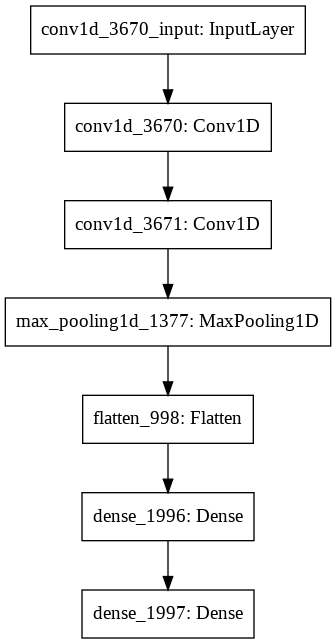

In [99]:
plot_model(model)

In [100]:
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit_generator(trainDataGen, epochs=50, validation_data=testDataGen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 13ms/step - loss: 0.0360 - val_loss: 0.0290
Epoch 2/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0319 - val_loss: 0.0104
Epoch 3/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0174
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0061 - val_loss: 0.0104
Epoch 5/50
37/37 [==============================] - 2s 58ms/step - loss: 0.0093 - val_loss: 0.0085
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0054 - val_loss: 0.0147
Epoch 7/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 8/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 10/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0117
Epoch 11/50
37/37

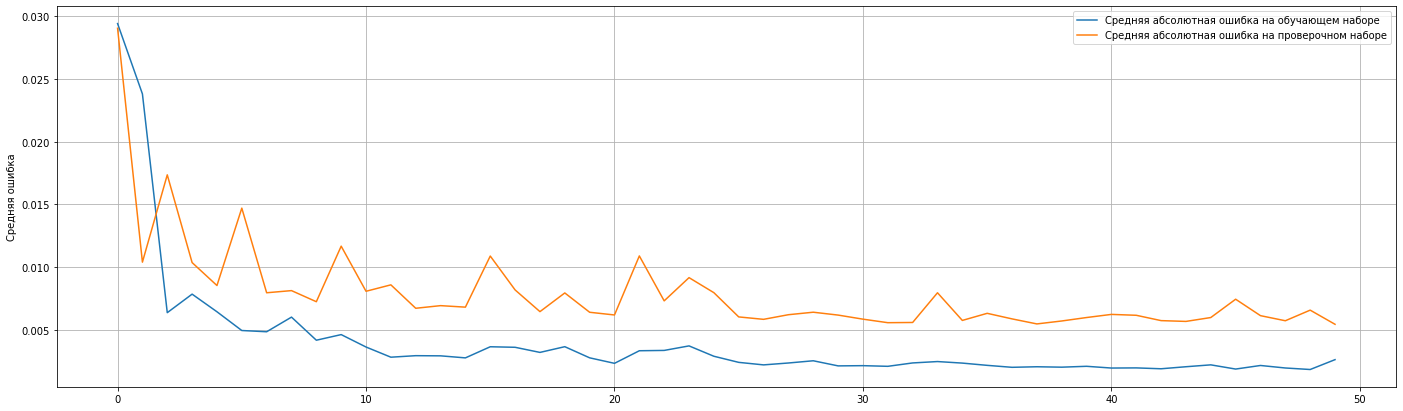

In [104]:
plt.figure(figsize=(24, 7))
plt.plot(history.history['loss'],label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

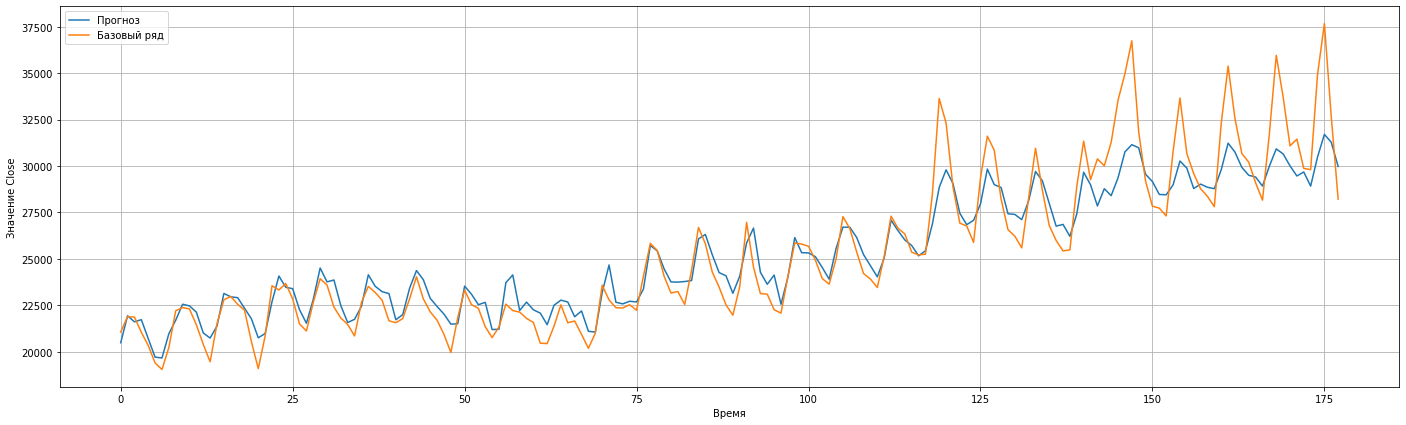

In [102]:
# Прогнозируем данные текущей сетью
currModel = model 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler)  #Прогнозируем данные
plt.figure(figsize=(24, 7))
plt.grid()
showPredict(0, 400, 0, predVal, yValUnscaled)

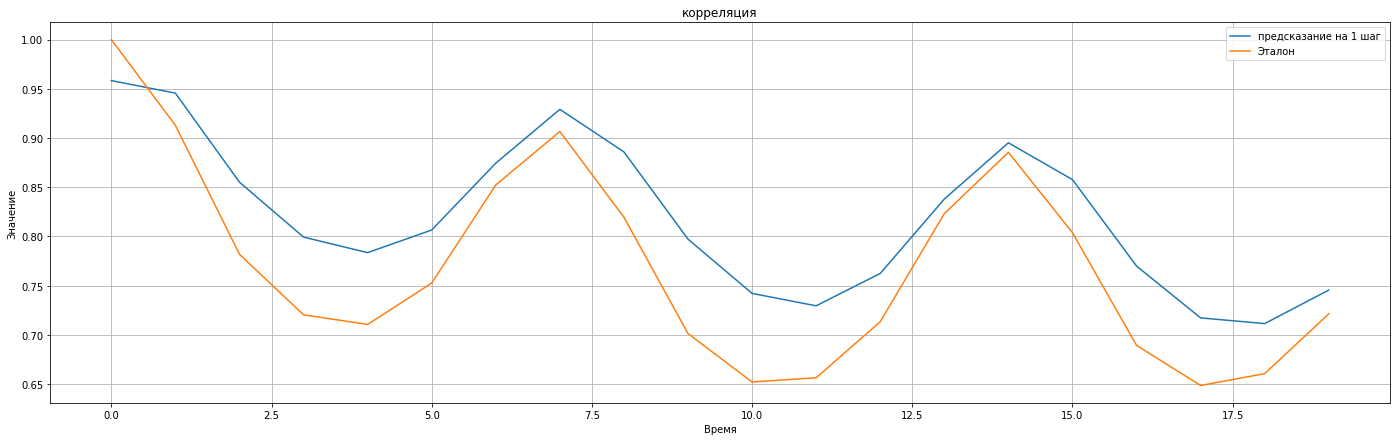

In [103]:
# Отображаем корреляцию, Используем выходной канал - только open, Проверяем корреляцию на глубину 60 шагов
plt.figure(figsize=(24, 7))
plt.title("корреляция")
plt.grid()
autoCorr([0], 20, predVal, yValUnscaled)

In [ ]:
# выводы: задание выполнено, генетический алгоритм рандомно выбрал конфигурацию. Однако графики показывают не высокую точность модели(( 